In [1]:
import pandas as pd
from pandas import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import glob
from tabulate import tabulate
import requests
import time

In [6]:
def get_extreme_values_and_days(data,data_cal,threshold,extreme_value_list,extreme_day_list):
    counter=0
    # Iterate through the list of data, and if it falls above the 90%ile, add it to EX_pmc_values
    # Also note the day on which that data point falls on
    for x in data :
        if x >= threshold:
            extreme_value_list.append(x)
            extreme_day_list.append(data_cal[counter])
        counter=counter+1

def find_compound_days(EX_pm25_days,EX_temps_days,compdays,numcompound_list):
    for pm25_day in EX_pm25_days:
        for temp_day in EX_temps_days:
            if pm25_day == temp_day:
                compdays.append(pm25_day)  
    compdays = [*set(compdays)]# Deletes duplicate days
    numcompound_list.append(len(compdays))

def find_compound_day_values(compdays,compound_value_list,parameter_table,parameter_calendar):

    #determine which temperature/PM2.5 value belongs to which day using indexing of original CSV data.
    for day in compdays:
        index= np.where(parameter_calendar==day)[0][0]
        compound_value_list.append(parameter_table[1,index])



In [10]:
def analyze(df,plotpm25,year_of_interest,numcompound_list,cityName):    
    
    # STEP 1: Extract the data

    pm25_df= df[df["Parameter Name"] == "PM2.5 - Local Conditions"]
    pm_cal=pm25_df["Day In Year (Local)"]
    temp_df = df[df["Parameter Name"] == "Ambient Max Temperature"]
    
    if temp_df.empty:
        # If temp_df is empty, select "Outdoor Temperature" (Not all the sensors I worked with contained the Ambient Max Temperature parameter
        temp_df = df[df["Parameter Name"] == "Outdoor Temperature"]
        
    temp_cal=temp_df["Day In Year (Local)"]

    pm25_raw_values= pm25_df["Arithmetic Mean"]
    temp_raw_values= temp_df["Arithmetic Mean"]    

    # Data extrapolated from CSV files must be converted from their initial form into a NumPy array, otherwise some Python 
    # functions like index() or len() will not work.

    #Let's determine the threshold for the 90%ile
    pm25Thresh=pm25_raw_values.quantile(q=0.9)
    pm25_raw_values=np.array(pm25_raw_values)
    pm_cal=np.array(pm_cal)
    
    tempsThresh=temp_raw_values.quantile(q=0.9)
    temp_raw_values=np.array(temp_raw_values)
    temp_cal=np.array(temp_cal)

    # 90%ile data lists (Here is where we store our dates of interest)
    EX_pm25_values= [] # Extreme PM2.5 Values
    EX_temps_values= [] # Extreme Temp Values
    EX_pm25_days= [] # Calendar Days where PM2.5 was extreme
    EX_temps_days=[]# Calendar Days where temp was extreme
    compdays=[] #The list of compund days before i do something to it (Originally "precompdays", we shall change ot compadays for sake of caLrity, if this doesnt work we can go back to teh original name.)
    counter=0

    

    # Iterate through the list of Particulate Matter data, and if it falls above the 90%ile, add it to EX_pm25_values.
    # Also note the day on which that data point falls on.
    get_extreme_values_and_days(pm25_raw_values,pm_cal,pm25Thresh,EX_pm25_values,EX_pm25_days)
    get_extreme_values_and_days(temp_raw_values,temp_cal,tempsThresh,EX_temps_values,EX_temps_days)

    find_compound_days(EX_pm25_days,EX_temps_days,compdays,numcompound_list)
             
    pm_table = np.vstack((pm_cal,pm25_raw_values))# Stack the dates and the assocated data points with each other
    temp_table = np.vstack((temp_cal,temp_raw_values))
    compound_pm25_values=[]
    compound_temp_values=[]

    find_compound_day_values(compdays,compound_pm25_values,pm_table,pm_cal)
    find_compound_day_values(compdays,compound_temp_values,temp_table,temp_cal)
   
    #Plot graph
    plt.rcParams["figure.figsize"] = [16.00, 7]
    plt.rcParams["figure.autolayout"] = True
    if plotpm25 == 0:
        plt.plot(pm_cal, pm25_raw_values, color="blue", label="PM 2.5 Changes")
        plt.scatter(EX_pm25_days, EX_pm25_values, color="limegreen", marker="o", label="Extreme PM2.5 days (90%ile)")
        plt.scatter(compdays, compound_pm25_values, color="red", marker="*", s=100, label="Compound day")
        plt.ylabel("Arithmetic Mean ($\mu$g/cm$^3$)")
    elif plotpm25 == 1:
        plt.plot(temp_cal, temp_raw_values, color="blue", label="Temperature Changes")
        plt.scatter(EX_temps_days, EX_temps_values, color="limegreen", marker="o", label="Extreme Temperature days (90%ile)")
        plt.scatter(compdays, compound_temp_values, color="red", marker="*", s=100, label="Compound day")
        plt.ylabel("Arithmetic Mean (°C)")
    plt.axvspan(172, 264, color='grey', alpha=0.1) #Highlights region of graph
    year_of_intereststr=str(year_of_interest)# Print the year of the graph
    title="Change in  PM 2.5 Concentration for " +cityName+  " Area (" + year_of_intereststr +")"
    plt.title(title)

    plt.legend()
    plt.xlabel("Day in Year")
    plt.show()

In [8]:
def main (plotpm25, cityName):
    
    df = pd.concat((pd.read_csv(f) for f in all_files))
   
    summary_table=[]# Table of dates to be printed to screen

    dfyears= df["Year"] # Collect all the years from the data
    dfyears = [*set(dfyears)] # Make sure all the years are unique
    year_of_interest=0 
    num_compound_days=[] # Where we will store the compound days
    countyName = df["County Name"].iloc[0]# Get the first instance of the County Name from the dataframe
    
    #Filter and plot each year available in the dataset
    for year in dfyears:
        year_of_interest=year
        rslt_df = df[df["Year"] == year_of_interest]
        analyze(rslt_df,plotpm25,year_of_interest,num_compound_days,cityName)
    
    #Create summary table 
    for i in range(len(dfyears)):
        summary_table.append([dfyears[i],countyName,num_compound_days[i]])
        
    return summary_table

# Co-extreme Days Charted in Anaheim Region

The graphs below depict the time series of daily PM2.5 concentrations in the city of Anaheim. The code can be changed to also give a time series of temperature if desired. Extreme days are marcated by green dots, while co-extreme days are marked by red stars. The grey shading marks the summer season, as it is expected for most of these co-extreme days to occur during the summer months.

NOTE: The 2023 graph stops abruptly due to the lack of data for the rest of the year at time of collection.

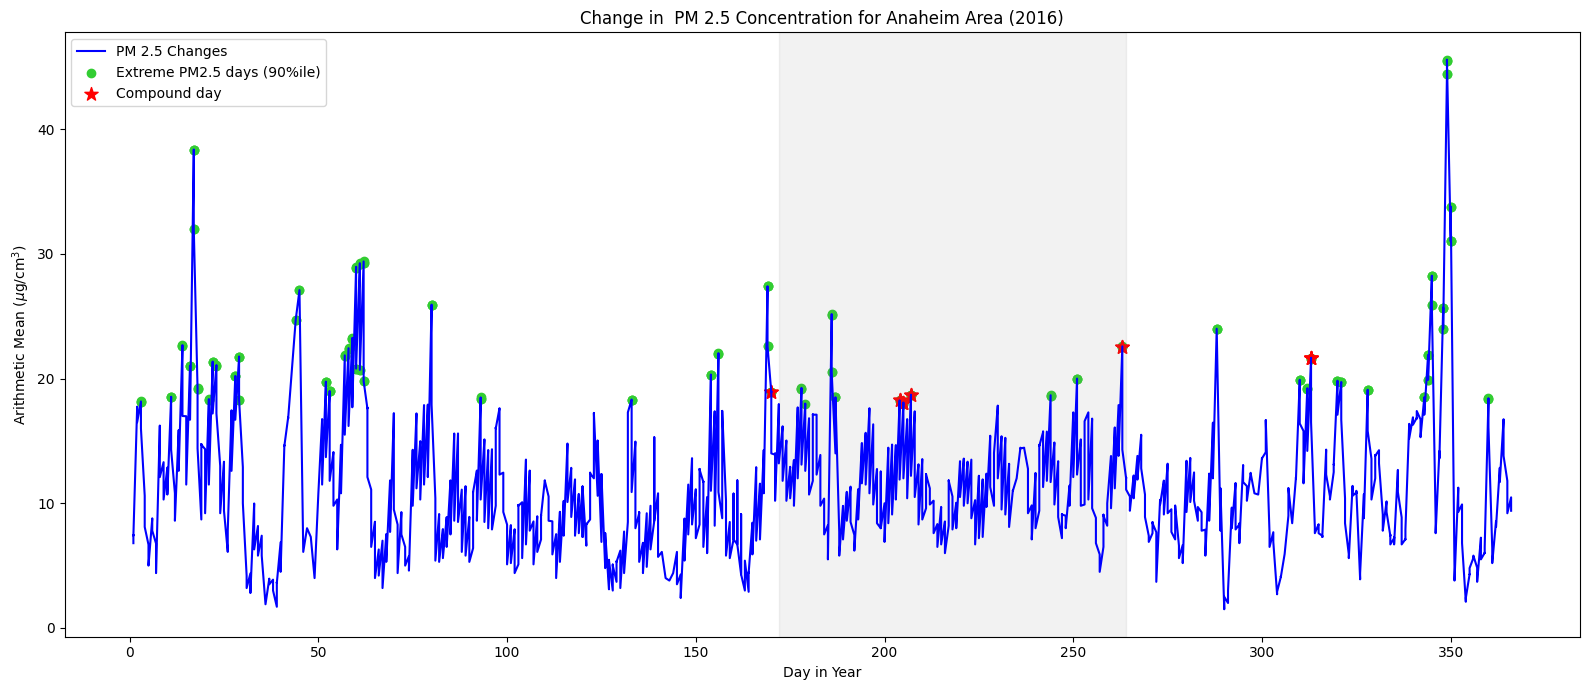

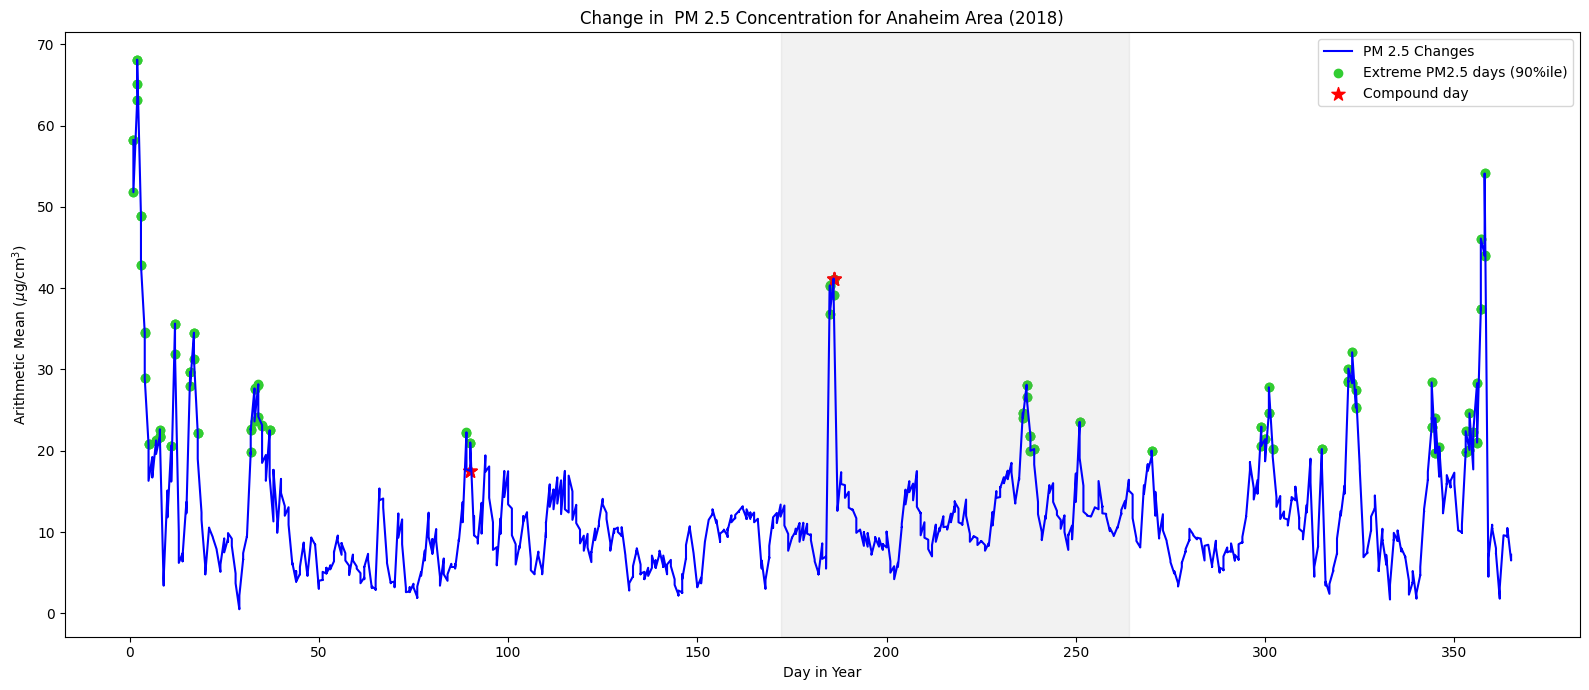

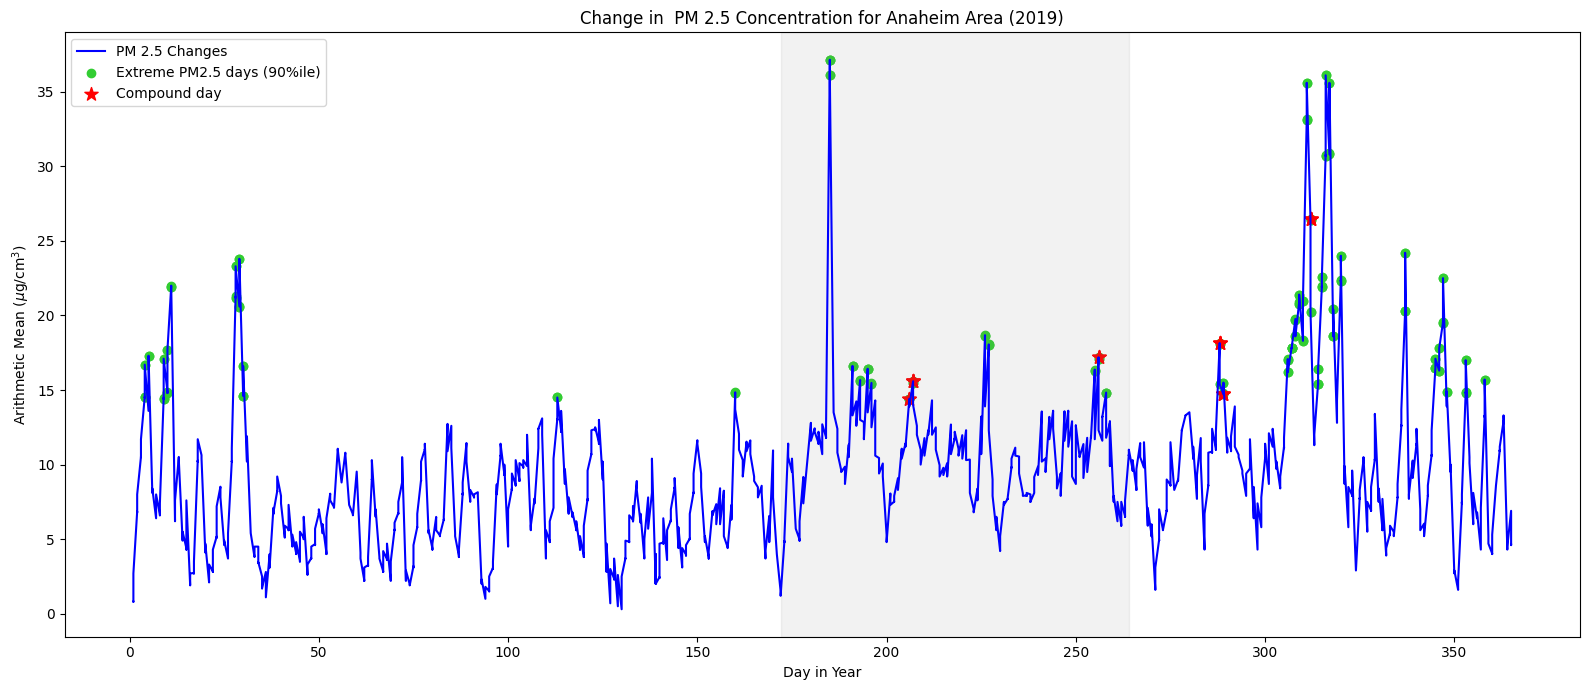

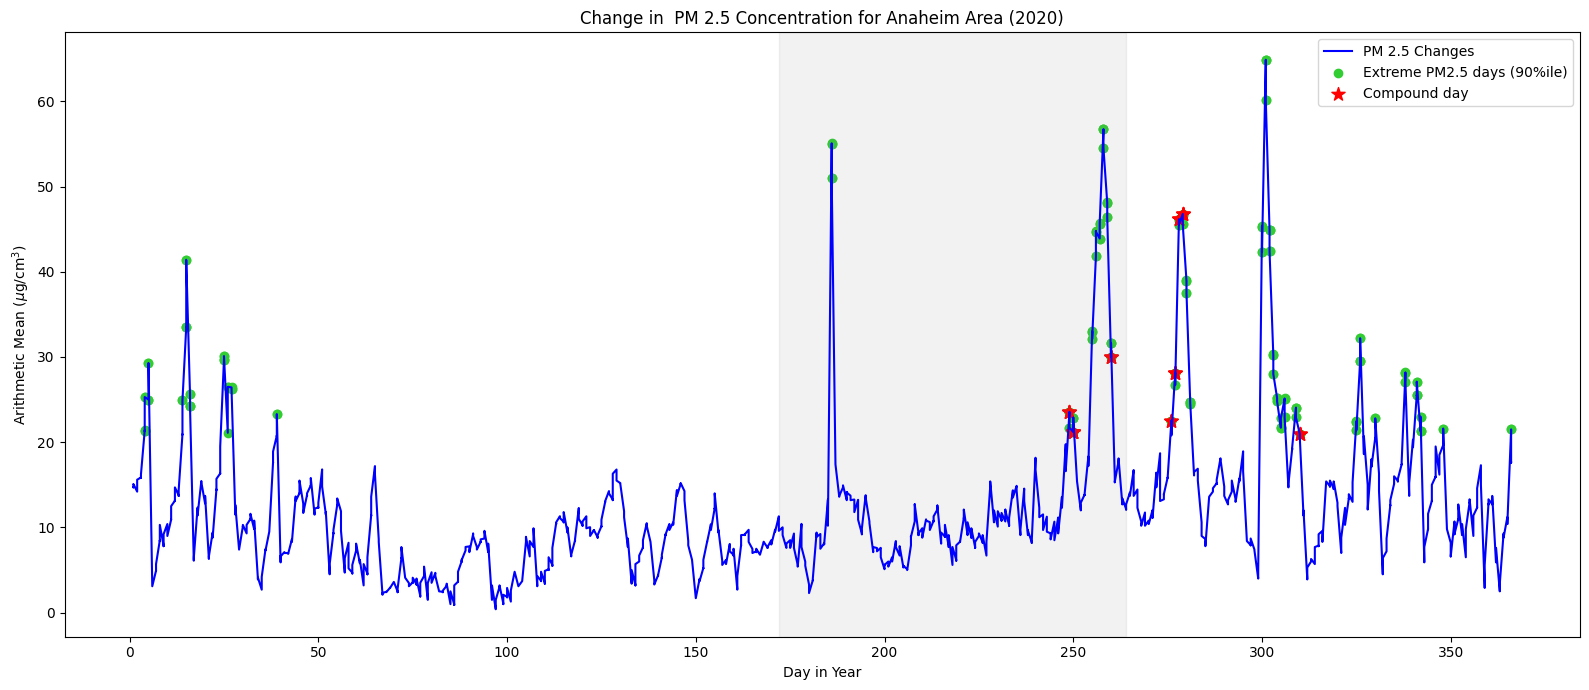

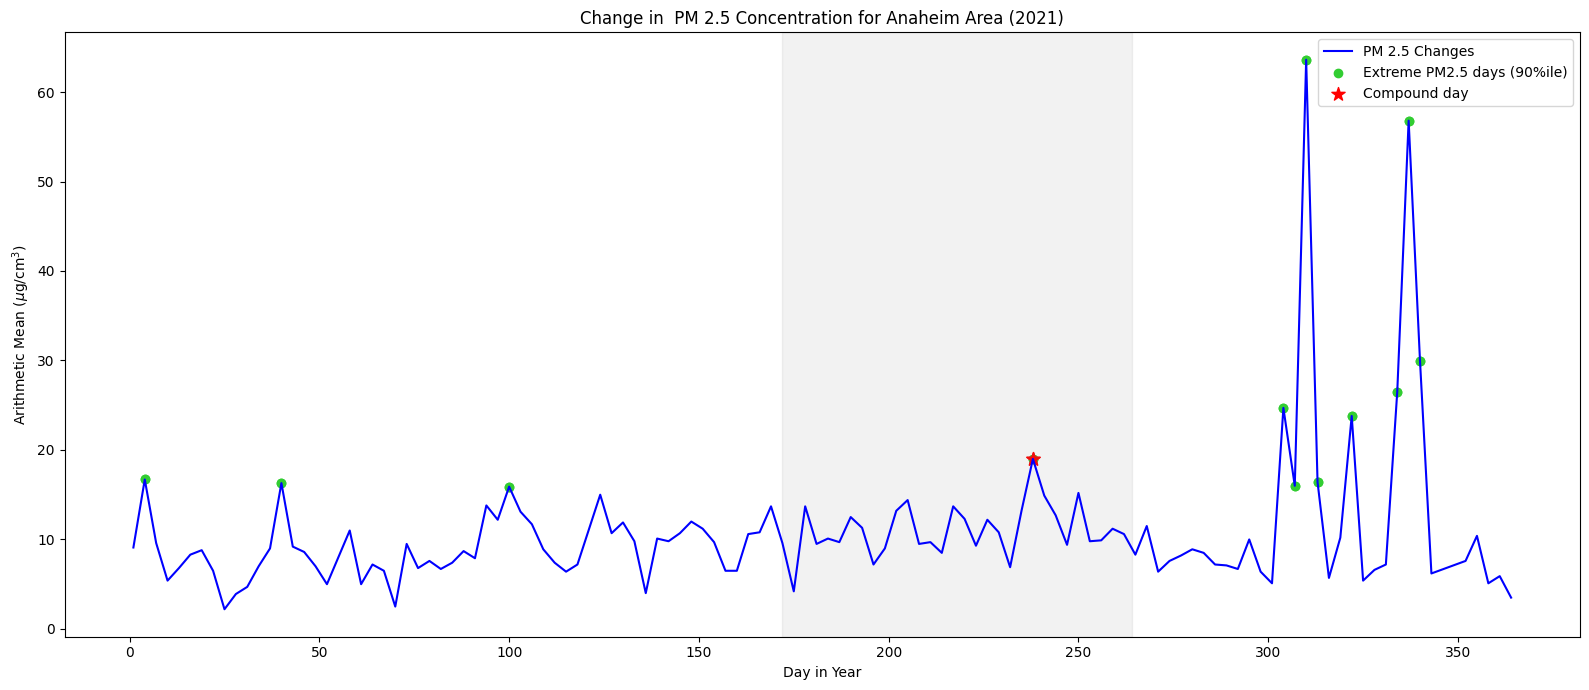

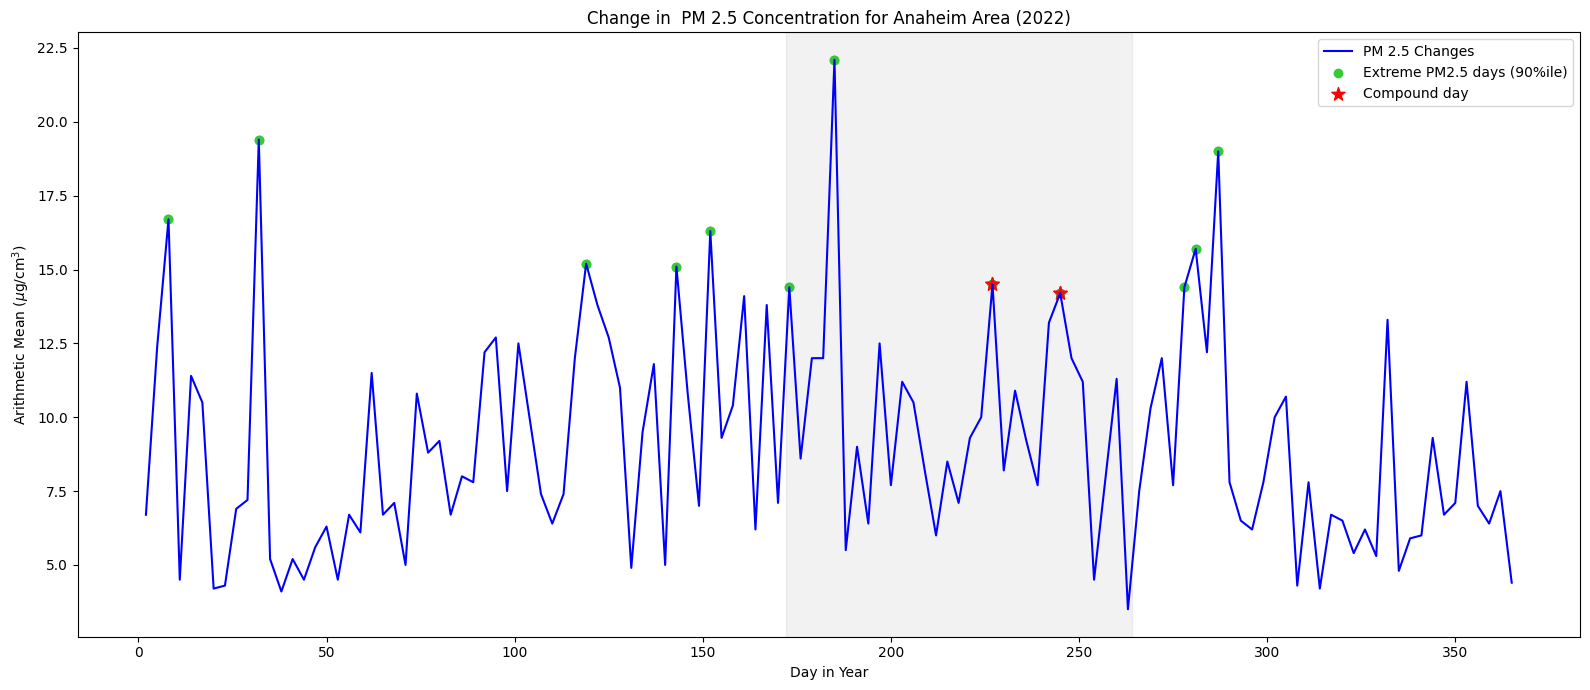

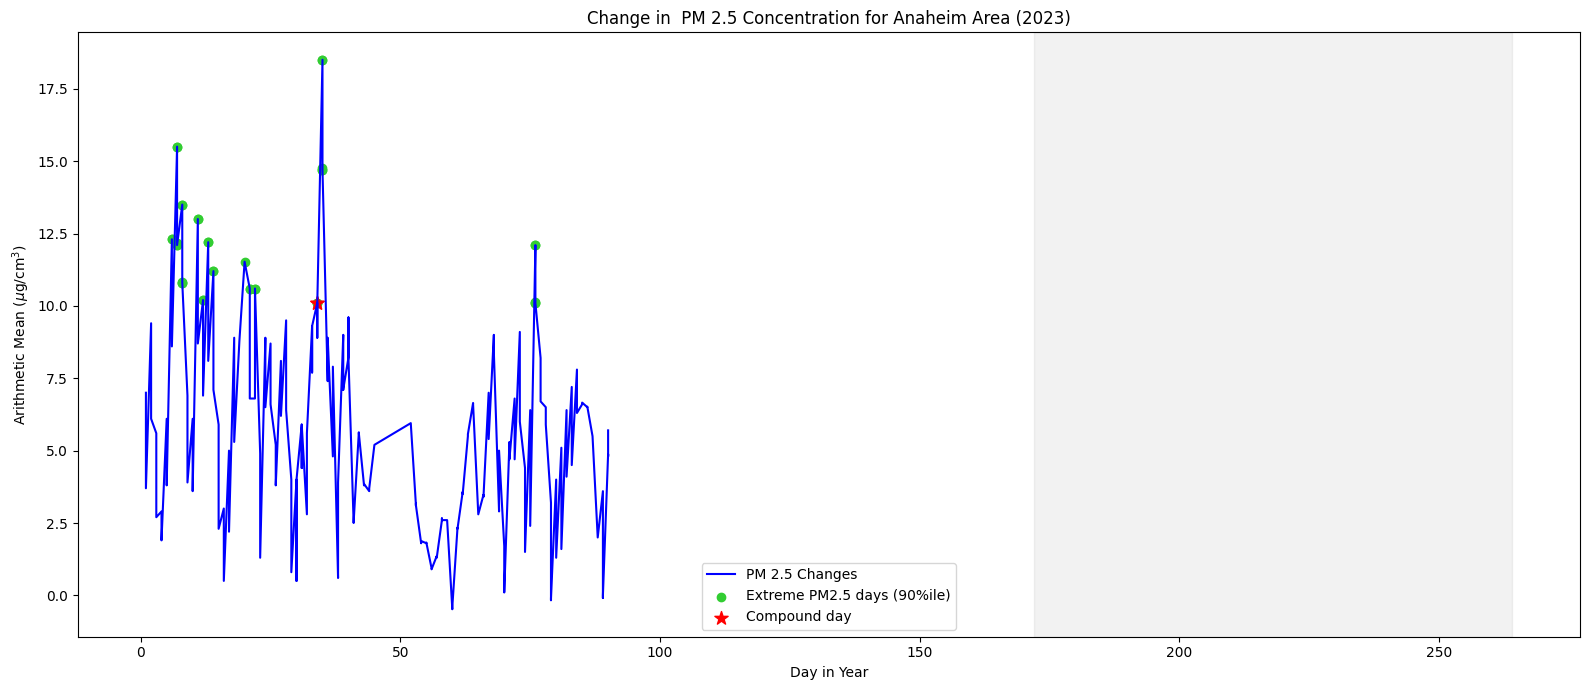

In [11]:
all_files = glob.glob("/Users/anthonyguzman/Downloads/anaheimdata/*")
plotpm25 = 0 # 0 for PM2.5, 1 for TEMP
summary_table=main(plotpm25,'Anaheim')
summary_table=np.array(summary_table)

Once the data is plotted, you can quickly create a table that summarizes the number of compound days per year.

In [12]:
print(tabulate(summary_table,headers=["Year","County Name","# of Compound days"]))

  Year  County Name      # of Compound days
------  -------------  --------------------
  2016  Orange                            6
  2018  Orange                            2
  2019  Orange                            6
  2020  Orange                            8
  2021  Orange                            1
  2022  Orange                            2
  2023  Orange                            1
